In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net_big

from RectifiedFlow import RectifiedFlow_Unet, train_rectified_flow_Unet_cond_10classes

from util import load_MNIST

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_MNIST(batch_size)
input_shape = (batch_size, 3, 32, 32)

In [4]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [6]:
rectified_flow_1 = train_rectified_flow_Unet_cond_10classes(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=10, noise_factor=0.005)
plt.plot(np.log(rectified_flow_1.loss_curve))
plt.show()

/home/max/Documents/RectifiedFlow/RectifiedFlow/RectifiedFlow.py:491: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels[indeces].clone().detach()).to(device)


IndexError: tensors used as indices must be long, byte or bool tensors

In [14]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_Allcond_Unet_big_flow1.pth")

In [7]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_Allcond_Unet_big_flow1.pth")

In [5]:
def one_hot_image(labels,device):
    shape = (labels.shape[0], 1, 32,32)
    labels_img = torch.zeros(shape).to(device)
    labels_img[np.arange(labels.shape[0]), 0, labels] = 1
    return labels_img

In [9]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device)

labels = torch.tensor([1 for i in range(20)]).to(device)
#labels = one_hot_image(labels, device)
img = rectified_flow_1.sample_ode_cond(img_init, labels, 100)
plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

labels = torch.tensor([0 for i in range(20)]).to(device)
#labels = one_hot_image(labels, device)
img = rectified_flow_1.sample_ode_cond(img_init, labels, 100)
plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

AttributeError: 'U_Net_big' object has no attribute 'device'

[]

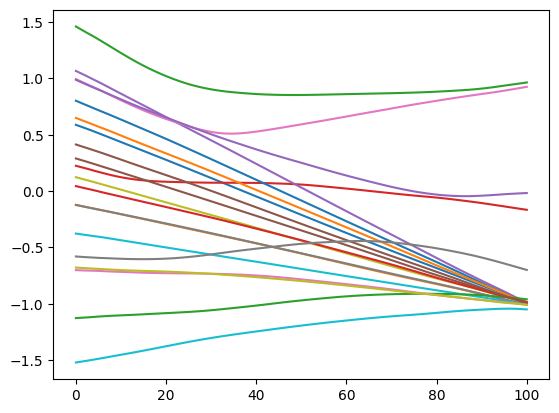

In [18]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,15,15].cpu().numpy())
plt.plot()

NameError: name 'rectified_flow_1' is not defined

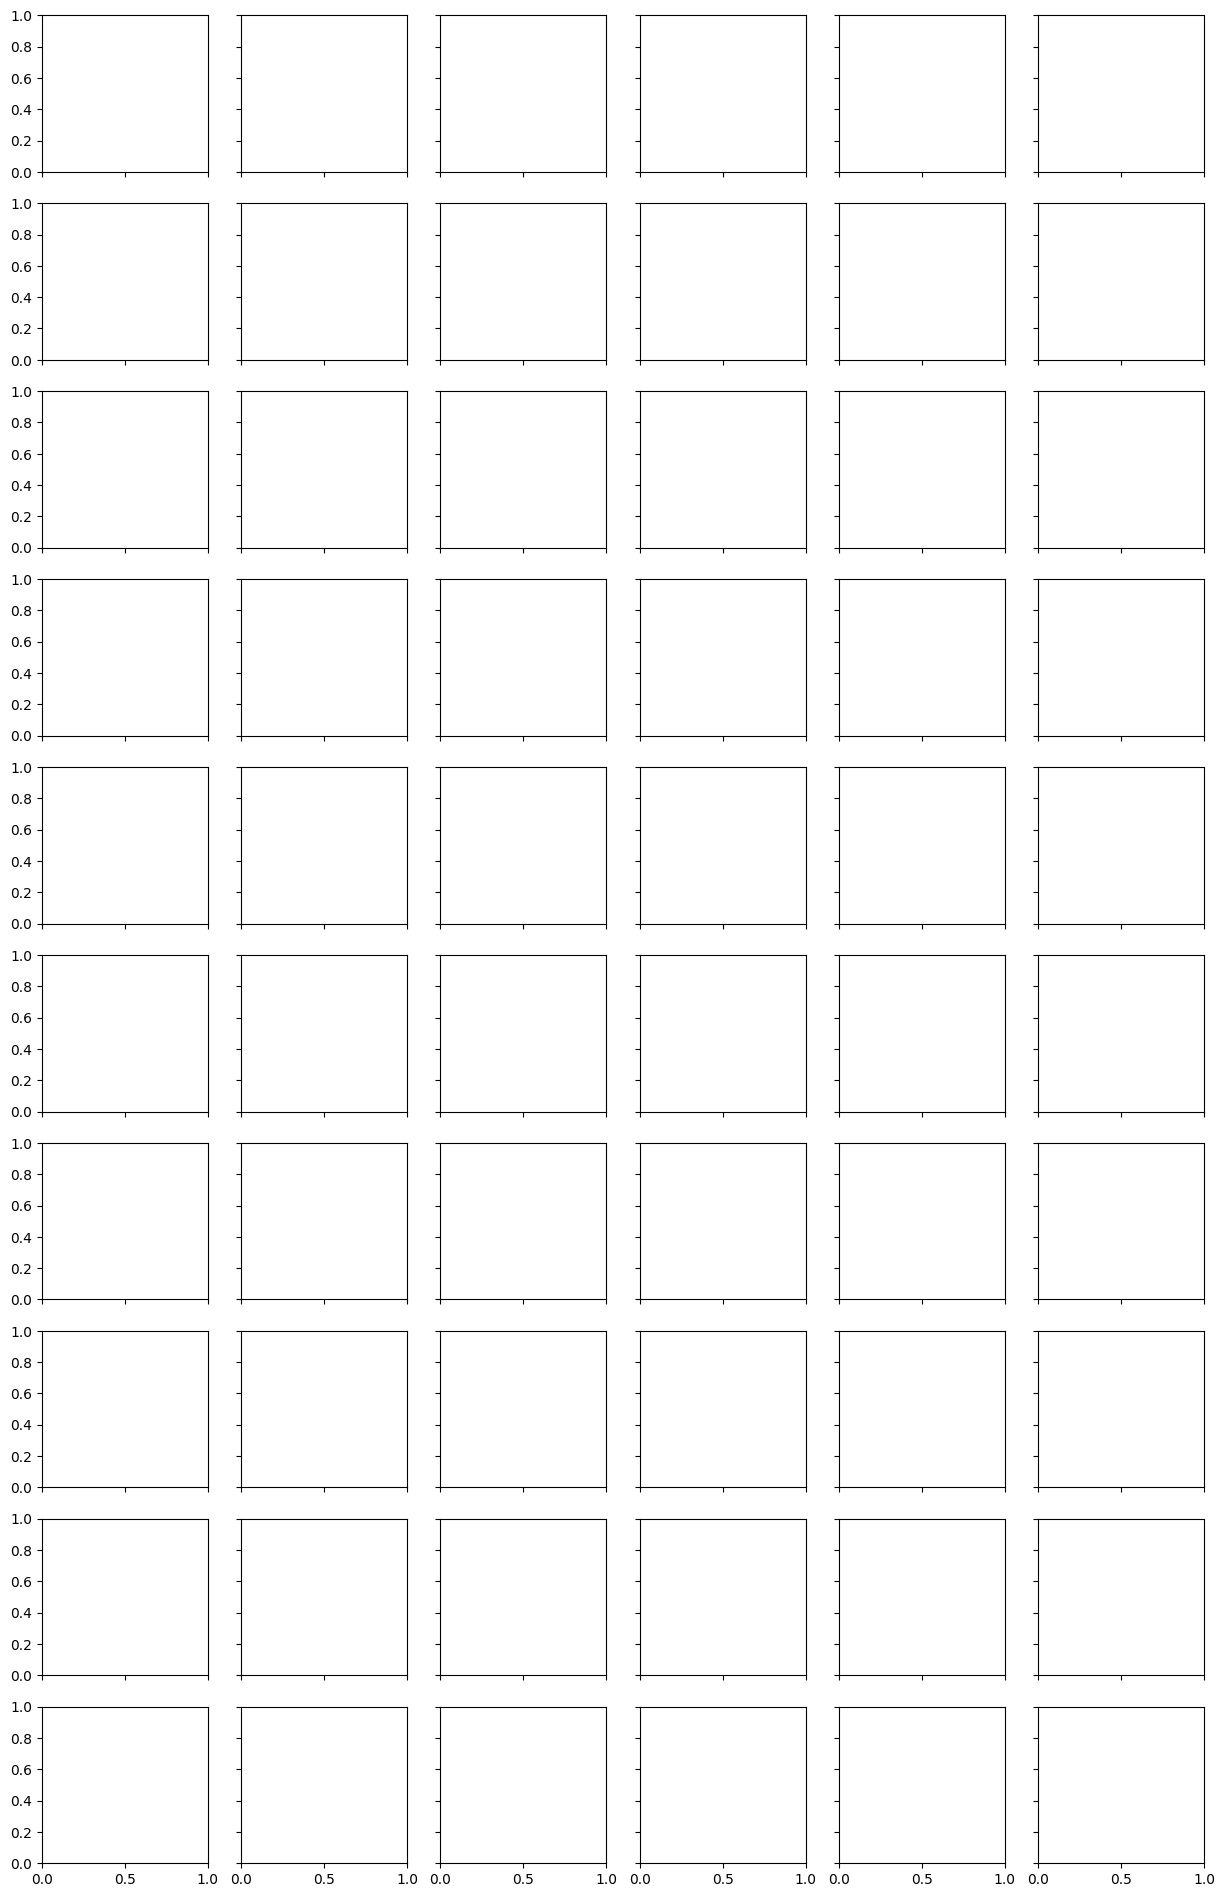

In [7]:
rows = 10
columns = 6
size = (15, 24)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    img_init = torch.randn(1,1,32,32).to(device) *0.8

    for row in range(rows):
        labels = torch.tensor([row]).to(device)
        labels = one_hot_image(labels, device)
        img = rectified_flow_1.sample_ode_cond(img_init, labels, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)
print(img[-1])
plt.show()

RuntimeError: stack expects each tensor to be equal size, but got [1, 1, 32, 32] at entry 0 and [1] at entry 2

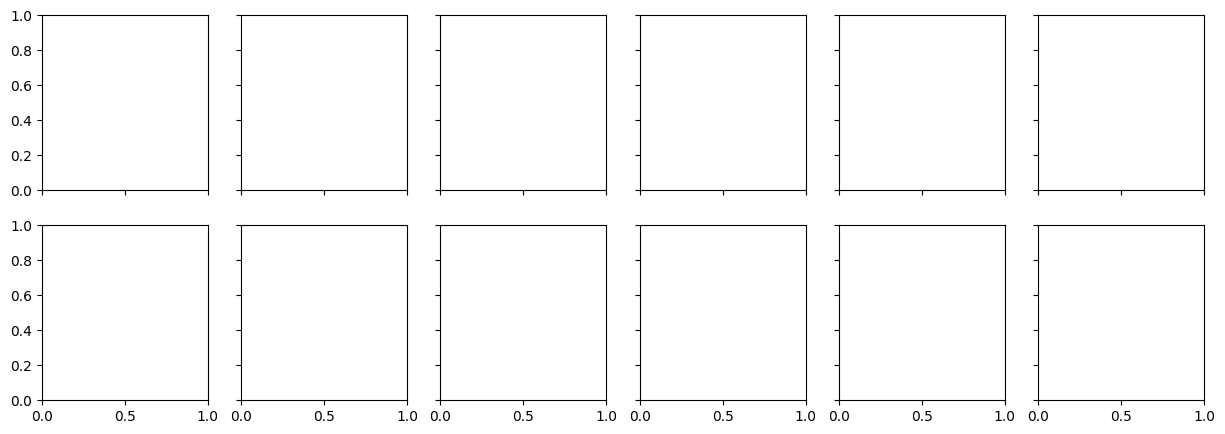

In [20]:
rows = 2
columns = 6
size = (15, 5)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    for batch in train_dataloader:
        batch,_ = batch
        img_init = batch[:1].reshape(1,1,32,32).to(device) + (torch.randn(1,1,32,32).to(device) * 0.01) - (torch.randn(1,1,32,32).to(device) * 0.01)
        break

    labels = torch.tensor([0]).to(device)
    img = rectified_flow_1.reverse_sample_ode_cond(img_init, labels, 100)[-1][0,0].detach().cpu().numpy()
    ax[0, column].imshow(img)

    labels = torch.tensor([1]).to(device)
    img = rectified_flow_1.reverse_sample_ode_cond(img_init, labels, 100)[-1][0,0].detach().cpu().numpy()
    ax[1, column].imshow(img)

plt.show()

In [ ]:
samples_init = torch.randn(2000,1,32,32).to(device) / 3 # do this sampeling in batches ?
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)

RuntimeError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 7.79 GiB total capacity; 4.95 GiB already allocated; 84.75 MiB free; 6.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
v_model_2 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_2 = RectifiedFlow_Unet(v_model_2, device)

In [ ]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=80, verbose=True)

In [ ]:
rectified_flow_2 = train_rectified_flow_Unet(rectified_flow_2, optimizer_2, scheduler_2, train_dataloader, device, epochs=60)

Epoch 00551: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00652: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00763: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00880: reducing learning rate of group 0 to 2.0480e-03.
Epoch 00961: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01042: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01123: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01278: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01359: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01440: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01521: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01602: reducing learning rate of group 0 to 3.4360e-04.
Epoch 01683: reducing learning rate of group 0 to 2.7488e-04.
Epoch 01764: reducing learning rate of group 0 to 2.1990e-04.
Epoch 01930: reducing learning rate of group 0 to 1.7592e-04.
Epoch 02011: reducing learning rate of group 0 to 1.4074e-04.
Epoch 02

In [ ]:
torch.save(rectified_flow_2, "./models/MNIST_newest_ref1.pth")

In [ ]:
rectified_flow_2 = torch.load("./models/MNIST_newest_ref1.pth")

tensor([[[[-0.9930, -1.0088, -1.0064,  ..., -1.0125, -1.0055, -0.9762],
          [-0.9936, -0.9874, -0.9879,  ..., -0.9942, -0.9839, -1.0150],
          [-0.9848, -0.9936, -0.9995,  ..., -0.9833, -1.0040, -0.9976],
          ...,
          [-0.9899, -1.0035, -1.0079,  ..., -1.0005, -0.9994, -0.9871],
          [-0.9933, -1.0009, -1.0023,  ..., -0.9963, -0.9966, -0.9948],
          [-0.9997, -1.0072, -1.0046,  ..., -0.9992, -0.9983, -0.9899]]],


        [[[-0.9801, -1.0077, -1.0098,  ..., -0.9986, -0.9884, -0.9866],
          [-0.9902, -0.9904, -1.0030,  ..., -1.0046, -0.9851, -0.9800],
          [-0.9845, -0.9931, -0.9984,  ..., -1.0118, -0.9973, -0.9819],
          ...,
          [-0.9918, -1.0022, -0.9894,  ..., -1.0016, -1.0048, -0.9975],
          [-0.9836, -0.9842, -0.9955,  ..., -1.0058, -1.0158, -0.9897],
          [-0.9819, -0.9891, -1.0031,  ..., -0.9978, -1.0025, -0.9883]]],


        [[[-0.9782, -1.0020, -0.9904,  ..., -1.0117, -0.9884, -0.9851],
          [-0.9910, -1.013

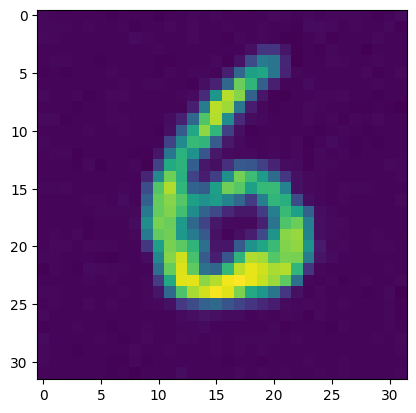

In [ ]:
rectified_flow_2.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device) / 3

img = rectified_flow_2.sample_ode(img_init, 3)

print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

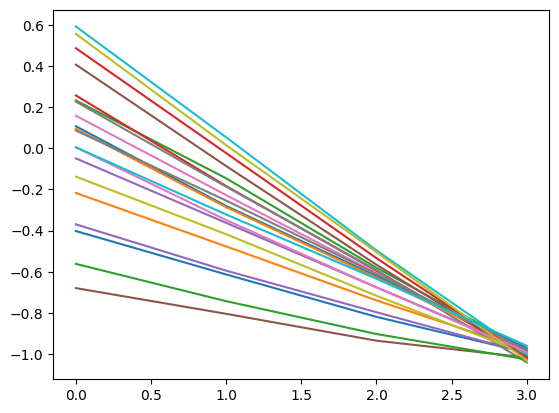

In [ ]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,0,0].cpu().numpy())
plt.plot()

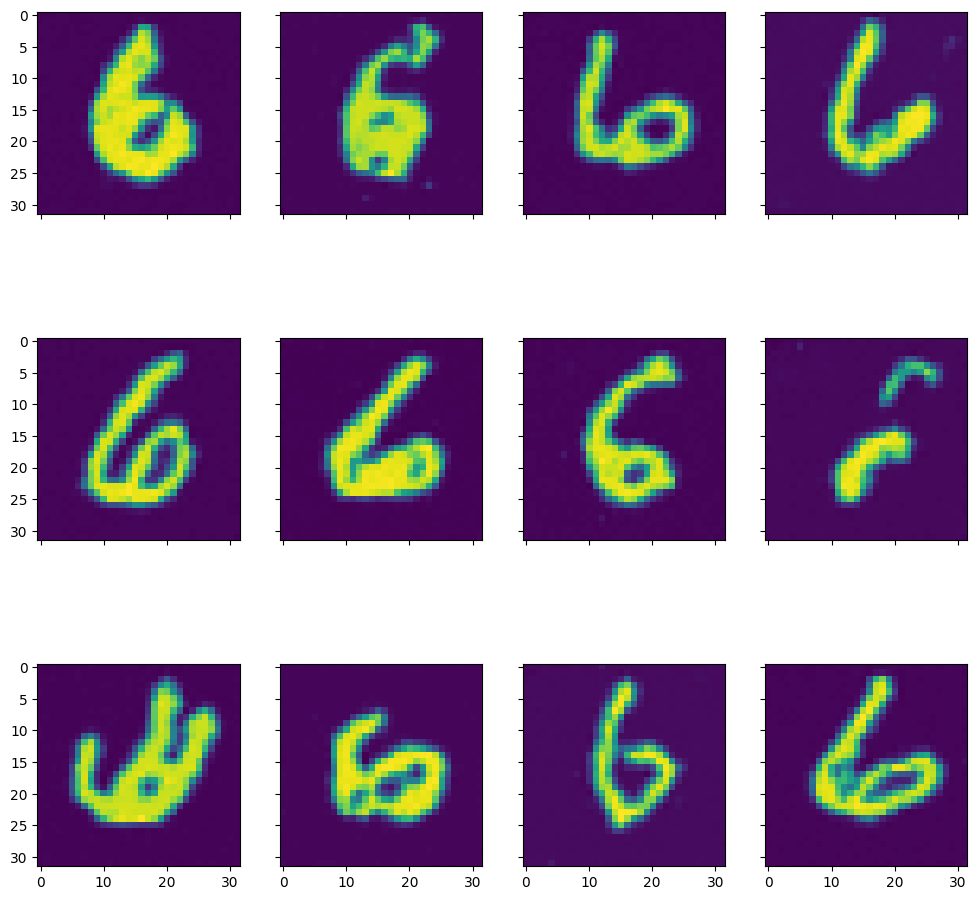

In [ ]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_2.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()

In [ ]:
def show_trajectories(rectified_flow):
    rectified